In [88]:
# Gute Fragestellung für datascience Projekt (Sportify)
# Gibt es einen Zusammenhang zwischen eigenen Musikgeschmack und der Geschmack der anderen?

# Importieren der benötigten Bibliotheken
import sys
import os as os
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

# Variablen und Funktionsdeklarationen

Um mit spotipy auf die Daten zugreiffen zu können, müssen `CLIENT_ID` und `CLIENT_SECRET` zwingendermassen gesetzt sein. Die Variablen `USERSANGEETHS` und `USERSTIAFEN` notwendig da wir mit der Spotipy methode `user_playlist` arbeiten.

In [89]:
CLIENT_ID = "082b3dd7a97642d49b60a647673caa75"
CLIENT_SECRET = "276e4715f8a14a34a7622c0105a8588c"
USERSANGEETHS = "qme120m1x3bg2wrtw3haiiyrb"
USERSTIAFEN = "stiafen"

client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API

In [90]:
# get all playlists of a user
def get_playlists(user):
    playlists = sp.user_playlists(user)
    playlist_ids = []
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            playlist_ids.append(playlist['id'])
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None
    return playlist_ids

In [91]:
playlistsSangeeths = get_playlists(USERSANGEETHS)
playlistsTiafen = get_playlists(USERSTIAFEN)

# get the name of the playlists, will later be used to print all available playlists for a user
def get_playlist_name(user, playlist_id):
    playlist = sp.user_playlist(user, playlist_id)
    return playlist['name'], playlist['id']


In [92]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    df = pd.DataFrame(tracks)
    df = df['track']
    df = df.apply(pd.Series)
    return df


In [93]:
#Funktion welche mittels user und playlist ID alle Tracks für eine Playlist ausgibt
def get_playlist_tracks_artists(user, playlist_id):
    results = sp.user_playlist_tracks(user, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [94]:
def get_audio_features(user, tracklist):
    #Dateinamen festlegen, falls vorhanden werden diese Daten ausgewertet statt Abfragen per API zu machen
    audiofeaturesfilename = user+"_audiofeatures.csv"

    if not os.path.isfile(audiofeaturesfilename):
        genres = []
        popularity = []
        features = []

        #Extract Audio Features
        for uri in tracklist['uri']:

            features = features+sp.audio_features(uri)


        #for artist in tracksStiafen['artists']:
        #    dictionary = artist[0]
        #    artistinfo = sp.artist(dictionary['id'])
        #    artistpopularity = artistinfo['popularity']
        #    artistgenres = artistinfo['genres']
        #    popularity.append(artistpopularity)
        #    genres.append(artistgenres)

        #Dataframe generieren

        audioFeatures = pd.DataFrame(features)
        audioFeatures['user'] = user
        #Daten exportieren

        audioFeatures.to_csv(audiofeaturesfilename)
        return audioFeatures

    else:
        audioFeatures = pd.read_csv(audiofeaturesfilename)
        return audioFeatures

Um nun die ID der playlist zu erhalten, in welcher wir unsere Lieblingssongs gespeichert haben nutzen wir die zuvor definierte Funktion `get_playlist_name` welche über das Resultat der Funktion `get_playlists` für den jeweiligen Benutzer läuft.
Um die Übersicht zu behalten haben wir unsere Playlists *Fav Songs "NAME"* genannt

In [95]:
for playlist in playlistsSangeeths:
    print(get_playlist_name(USERSANGEETHS, playlist))

for playlist in playlistsTiafen:
    print(get_playlist_name(USERSTIAFEN, playlist))

('Testo pur🏋🏽', '7o70luarSZS5DHoODMH51U')
('Fav Songs Sangeeths', '2E7GAf1h3F19ezc18w1NpZ')
('Tamil Vibes', '64Lq6W07GIOs087K88iOzT')
('Arabic  Vibes', '1Rr83zHLDULxQDbC9taydm')
('Albanien Vibes', '6jyy1HUool6rj0xWLVsAPC')
('UK DRILL ', '5ycwKESGY1Z71ftYWmTVJs')
('Baba Vibes', '67a5HCEjwm4aXvjPVoxoAX')
('Fav Songs Stiafen', '0ekbyk9EKkCf4MBjrQoM2D')
('Favorite Songs', '4DeCJm3aeeb0TTdthf8MGY')
('Caterpillar (feat. Eminem & King Green)', '1JKSl9B6hJNCGFs9FdOq8I')
('Meine Playlist Nr.\xa034', '3uBDJVShkGJKFxPNnjC7IL')
('Dein Mixtape\xa06 - ZUSAMMENGESTELLT FÜR STIAFEN:21.06.19', '48I13UCIzloZpyRE23zwIa')
('Mixtape 3', '2jnqcj5CxaBLHjzVafdmce')
('Oldschool', '4RjDNPzba04zlAan0a4bTE')


# Datensatz laden, filtern und verstehen
Nun da wir die Playlist ID haben können wir die Tracks aus unseren Fav Songs Playlists auslesen und mittels unserer Funktion die audio Features extrahieren.
Zuerst schreiben wir also alle Tracks mit deren Informationen in eine Liste `tracksSangeeths` und `tracksStiafen`

In [96]:
#Variablen für Playlists Sangeeths und Stiafen
favoritplaylistSangeeths = "2E7GAf1h3F19ezc18w1NpZ"
favoritplaylistStiafen = "0ekbyk9EKkCf4MBjrQoM2D"

# Für Beide User wird eine Liste mit den Trackinfos erstellt
tracksSangeeths = get_playlist_tracks(USERSANGEETHS, favoritplaylistSangeeths)
tracksStiafen = get_playlist_tracks(USERSTIAFEN, favoritplaylistStiafen)

Nun holen wir alle Audio features mit unserer Methode und speichern diese in dem Dataframe *rawAudioFeaturesTotal*.

In [97]:
audioFeaturesStiafen = get_audio_features("Stiafen", tracksStiafen)
audioFeaturesSangeeths = get_audio_features("Sangeeths", tracksSangeeths)
#Um über das Gesamtbild der Daten eine aussage machen zu können nehmen wir beide Dataframes in eines
rawAudioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)


C:\Users\Startklar\AppData\Local\Temp\ipykernel_18364\1232690623.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rawAudioFeaturesTotal = audioFeaturesStiafen.append(audioFeaturesSangeeths)


Wir säubern nun noch die Rohdaten ein wenig

In [98]:
if "Unnamed: 0" in rawAudioFeaturesTotal:
    rawAudioFeaturesTotal.drop("Unnamed: 0", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("analysis_url", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("id", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("uri", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("type", axis=1, inplace=True)
rawAudioFeaturesTotal.drop("track_href", axis=1, inplace=True)

Wie wir nun sehen sind viele der Spalten für unser Modell nicht von Bedeutung, da es ausschliesslich *danceability* und *energy* als Features benötigt. Im Dataframe welchen wir für unser Unsupervised Machine Learning einsetzen können wir daher alle ausser diesen Zwei Spalten entfernen

In [99]:
audioFeaturesTotal = rawAudioFeaturesTotal.copy()
#Es muss bemerkt werden das die Spalte *Unnamed: 0* ein Nebenprodukt des CSV imports ist.
audioFeaturesTotal.drop("key", axis=1, inplace=True)
audioFeaturesTotal.drop("duration_ms", axis=1, inplace=True)
audioFeaturesTotal.drop("time_signature", axis=1, inplace=True)
audioFeaturesTotal.drop("user", axis=1, inplace=True)
audioFeaturesTotal.drop("mode", axis=1, inplace=True)
audioFeaturesTotal.drop("loudness", axis=1, inplace=True)
audioFeaturesTotal.drop("speechiness", axis=1, inplace=True)
audioFeaturesTotal.drop("acousticness", axis=1, inplace=True)
audioFeaturesTotal.drop("instrumentalness", axis=1, inplace=True)
audioFeaturesTotal.drop("liveness", axis=1, inplace=True)
audioFeaturesTotal.drop("valence", axis=1, inplace=True)
audioFeaturesTotal.drop("tempo", axis=1, inplace=True)

Nun verschaffen wir uns einen überblick wie die Daten aussehen

In [100]:
audioFeaturesTotal.describe()

,danceability,energy
count,1450.000000,1450.000000
mean,0.526701,0.405721
std,0.242342,0.319077
min,0.060600,0.000962
25%,0.309250,0.055800
50%,0.545500,0.488000
75%,0.752750,0.700000
max,0.962000,0.986000


In [101]:
audioFeaturesTotal.head()

,danceability,energy
0,0.0614,0.05800
1,0.2990,0.00626
2,0.0877,0.07630
3,0.1760,0.05340
4,0.4280,0.00300


In [102]:
audioFeaturesTotal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 798
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   danceability  1450 non-null   float64
 1   energy        1450 non-null   float64
dtypes: float64(2)
memory usage: 34.0 KB


# Data Quality Assesment
Im Data Quality Assesment schauen wir uns noch Nullwerte und die Min, Max Werte der Spalten an

In [103]:
audioFeaturesTotal.isnull().sum()

danceability    0
energy          0
dtype: int64

Um die Min Max Werte der Spalten zu erhalten nutzen wir nochmals die describe Methode. Die Werte sehen realistisch aus

In [104]:
audioFeaturesTotal.describe()

,danceability,energy
count,1450.000000,1450.000000
mean,0.526701,0.405721
std,0.242342,0.319077
min,0.060600,0.000962
25%,0.309250,0.055800
50%,0.545500,0.488000
75%,0.752750,0.700000
max,0.962000,0.986000


# Data Preprocessing
Um die Datenstandardisierung durchzuführen nutzen wir den Standard Scaler

In [105]:

X = audioFeaturesTotal
scaler =  StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.92068144, -1.090145  ],
       [-0.93990997, -1.25235595],
       [-1.81211962, -1.03277236],
       ...,
       [ 0.85982218,  0.65611512],
       [ 0.17460306,  0.43979206],
       [ 1.16940913,  0.42411647]])

# Datenvisualisierungen
Da wir mit K-Means arbeiten wollen, haben wir einerseits einen Countplot und einen Scatterplot eingesetzt

Im untenstehenden Countplot wollten wir sicherstellen, das von beiden Personen etwa die gleiche Menge an Daten verfügbar ist.

<AxesSubplot:xlabel='user', ylabel='count'>

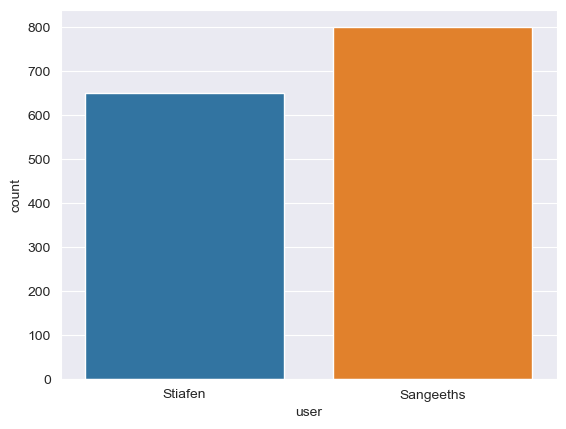

In [106]:
sns.countplot(x = rawAudioFeaturesTotal["user"])

Die Untenstehende Grafik zeigt für die von der Aufgabenstellung gegebenen Features eine klare Clusterbildung für die beiden Personen

<AxesSubplot:xlabel='energy', ylabel='danceability'>

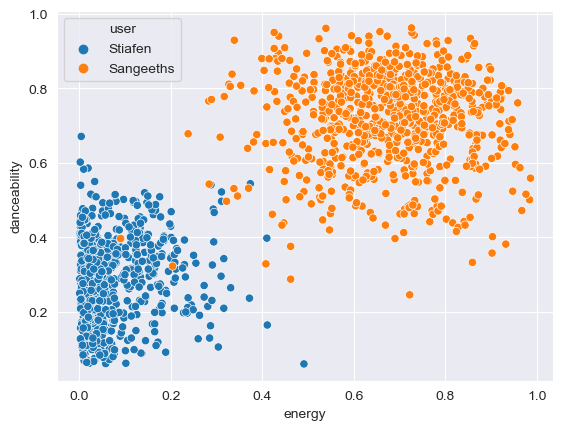

In [107]:
sns.scatterplot(data=rawAudioFeaturesTotal, x="energy", y="danceability", hue="user")

# Kmeans

In [108]:
inertias = []
K = range(1,10)
for k in tqdm_notebook(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    inertias.append(kmeanModel.inertia_)

C:\Users\Startklar\AppData\Local\Temp\ipykernel_18364\3735422277.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(K):


  0%|          | 0/9 [00:00<?, ?it/s]

C:\Users\Startklar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


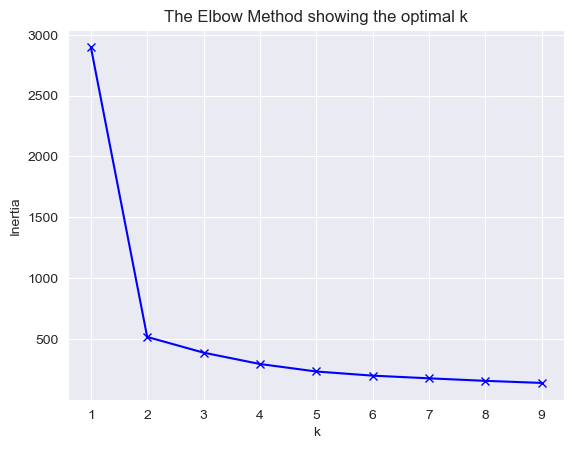

In [109]:
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')

plt.plot(K, inertias, 'bx-')

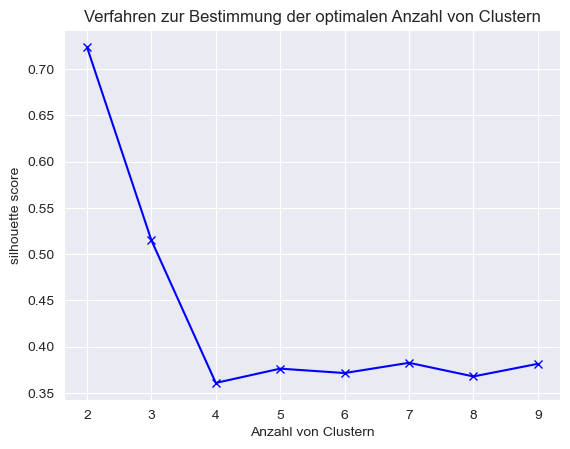

In [110]:
k_values = range(2, 10)
scores = []

for k in k_values:

  model = KMeans(n_clusters=k)

  model.fit(X)
  # silhouette score für das Modell berechnen
  score = silhouette_score(X, model.labels_)
  scores.append(score)

# Plot der silhouette scores gegenüber der Anzahl von Clustern erstellen
plt.plot(k_values, scores, 'bx-')
plt.xlabel('Anzahl von Clustern')
plt.ylabel('silhouette score')
plt.title('Verfahren zur Bestimmung der optimalen Anzahl von Clustern')
plt.show()

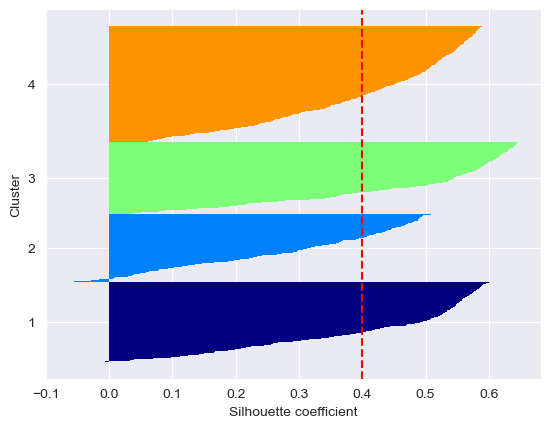

In [111]:
from matplotlib import cm
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# ANzahl der Cluster festlegen mit shilouette plot_silhouette
def plot_silhouette(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_vals = silhouette_samples(X, labels)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(np.unique(labels)):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, np.unique(labels) + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.show()

plot_silhouette(X_scaled, 4)

In [112]:
# fit model with method
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)

KMeans(n_clusters=2)

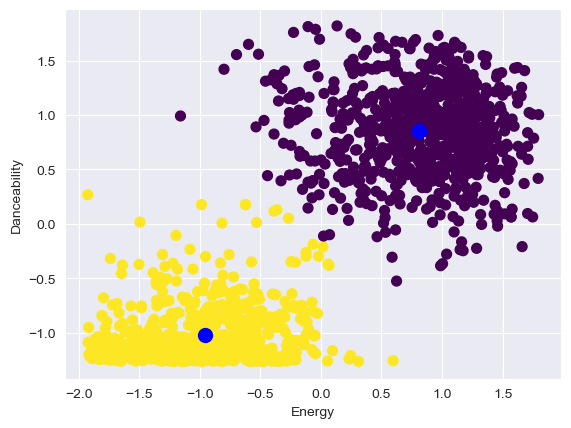

In [113]:
# Using the predict method of KMeans to predict 2 clusters using the sample data
features = ["energy", "danceability"]

predicted = kmeans.predict(X_scaled)
df_X_scaled = pd.DataFrame(X_scaled, columns=features)
df_X_scaled.columns = ["Energy", "Danceability"]

# scatter plot with predictions
plt.scatter(df_X_scaled["Energy"], df_X_scaled["Danceability"], c=predicted, s=50, cmap='viridis')
plt.xlabel("Energy")
plt.ylabel("Danceability")

centers = kmeans.cluster_centers_
# plot centers
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=100, alpha=1);

<AxesSubplot:xlabel='energy', ylabel='danceability'>

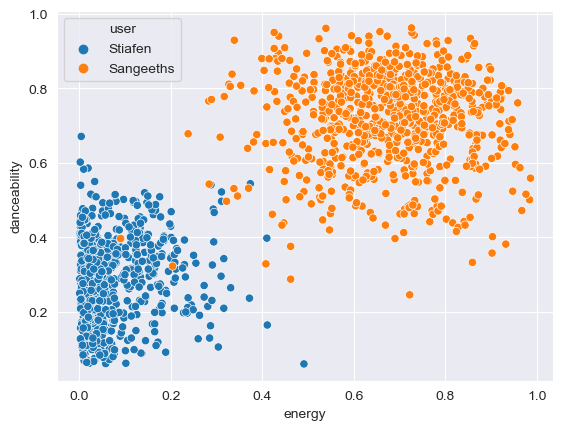

In [114]:
sns.scatterplot(x='energy', y='danceability', hue=rawAudioFeaturesTotal["user"], data=rawAudioFeaturesTotal)

In [115]:
matrix = pd.DataFrame({'labels': predicted, 'user': rawAudioFeaturesTotal["user"]})
ct = pd.crosstab(matrix['labels'], matrix['user'])
ct

user,Sangeeths,Stiafen
labels,,
0,786,1
1,13,650


In [116]:
rawAudioFeaturesTotal

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user
0,0.0614,0.05800,2,-20.976,1,0.0418,0.9180,0.91500,0.1490,0.0329,58.193,1463704,4,Stiafen
1,0.2990,0.00626,9,-30.923,1,0.0478,0.9940,0.90100,0.0823,0.0634,69.043,378733,4,Stiafen
2,0.0877,0.07630,9,-23.986,1,0.0429,0.6450,0.89700,0.3530,0.0509,78.535,295219,4,Stiafen
3,0.1760,0.05340,10,-27.626,1,0.0406,0.9700,0.91500,0.2900,0.0332,71.673,132120,5,Stiafen
4,0.4280,0.00300,0,-31.005,1,0.0709,0.9950,0.92400,0.0889,0.0934,69.108,407947,3,Stiafen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.5940,0.80300,6,-6.269,1,0.2650,0.0449,0.00000,0.2370,0.2580,84.781,145322,4,Sangeeths
795,0.6020,0.52600,11,-8.748,1,0.4010,0.1470,0.00000,0.0874,0.5120,72.661,134480,3,Sangeeths
796,0.7350,0.61500,4,-6.463,0,0.0670,0.0281,0.00444,0.0517,0.4060,97.912,113878,4,Sangeeths
797,0.5690,0.54600,9,-8.306,0,0.4510,0.3380,0.00000,0.0507,0.6340,96.796,196000,4,Sangeeths


# DBSCAN

In [120]:
# reload data set. We only need Column "Species" for validation, not training!
data = rawAudioFeaturesTotal

# drop null values
data = data.dropna()

# drop Species (target) from train data
X = data.drop(['user'], axis=1).values

# use standard scaler and transform
scaler = StandardScaler()
X = scaler.fit_transform(X) 

# get species for validation
y = data['user']
user = {'Sangeeths': 0, 'Stiafen': 1}
y = [user[item] for item in y]
y = np.array(y)

[[-1.92068144 -1.090145   -0.93824611 ... -1.6670962   5.17064986
   0.26479748]
 [-0.93990997 -1.25235595  1.02610992 ... -1.32516412  0.44365133
   0.26479748]
 [-1.81211962 -1.03277236  1.02610992 ... -1.0260287   0.07979778
   0.26479748]
 ...
 [ 0.85982218  0.65611512 -0.37700153 ... -0.41537266 -0.71026817
   0.26479748]
 [ 0.17460306  0.43979206  1.02610992 ... -0.45054282 -0.35247927
   0.26479748]
 [ 1.16940913  0.42411647 -1.49949069 ...  0.9060609  -0.3788074
   0.26479748]]


In [122]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score


dbscan = DBSCAN(eps = 0.89, min_samples=74)
dbclusters = dbscan.fit_predict(X)
accuracy_score(dbclusters, y)

0.0

In [119]:
# create DataFrames from data
df_dbclusters = pd.DataFrame(dbclusters)
df_X = pd.DataFrame(X)

# add column names
df_dbclusters.columns = ['user']
df_X.columns = ["energy", "danceability"]

# concat both dataframes
df_predicted = pd.concat([df_X, df_dbclusters], axis="columns")

# scatter plot
sns.scatterplot(x='energy', y='danceability', hue = 'user', data = df_predicted, legend = None)

ValueError: Length mismatch: Expected axis has 13 elements, new values have 2 elements